## Creating dataset and splitting it

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# 1. Define the Custom Dataset
class CustomerDataset(Dataset):
    def __init__(self, num_samples=2000):
        # 1. Create Features (X)
        self.features = torch.randn(num_samples, 20)
        
        # 2. Define a hidden "True Relationship" (Weights)
        # Let's say Credit Score depends heavily on the first 5 features
        self.true_weights = torch.randn(20, 1) 
        
        # 3. Calculate Target (Y) based on X
        # Formula: y = (X * weights) + Bias + Noise
        base_score = self.features @ self.true_weights
        
        # Scale it to look like credit scores (e.g., mean 650, std 100)
        self.credit_labels = (base_score * 20) + 650 
        
        # Target 1: Churn (Binary) - Let's make it depend on the score too
        # If score is low, churn is higher
        probabilities = torch.sigmoid((650 - self.credit_labels) / 50)
        self.churn_labels = torch.bernoulli(probabilities)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y_churn = self.churn_labels[idx]
        y_credit = self.credit_labels[idx]
        return x, y_churn, y_credit

# 2. Create DataLoaders
dataset = CustomerDataset()
# Split into Train and Test (80/20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

print(f"Batch Shape: {next(iter(train_loader))[0].shape}") 

Batch Shape: torch.Size([1600, 20])


In [2]:
train_features, train_churn_labels, train_credit_labels = next(iter(train_loader))
test_features, test_churn_labels, test_credit_labels = next(iter(test_loader))

In [3]:
train_features.shape, train_churn_labels.shape, train_credit_labels.shape, test_features.shape, test_churn_labels.shape, test_credit_labels.shape

(torch.Size([1600, 20]),
 torch.Size([1600, 1]),
 torch.Size([1600, 1]),
 torch.Size([400, 20]),
 torch.Size([400, 1]),
 torch.Size([400, 1]))

## Regression Task

### Model Building

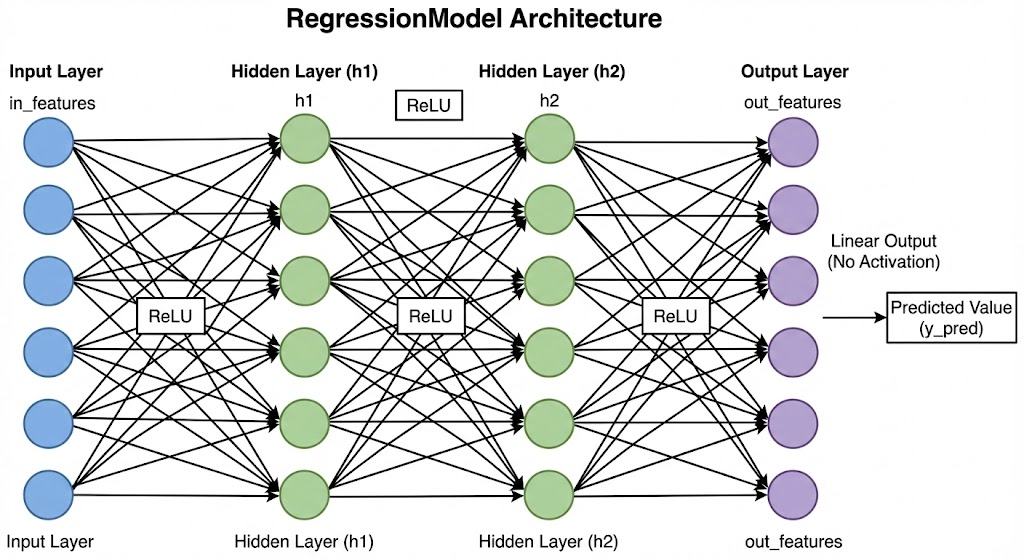

In [4]:
class RegressionModel(nn.Module):
    def __init__(self, in_features, h1, h2, out_features):
        super().__init__()
        self.input_layer = nn.Linear(in_features=in_features, out_features=h1)
        self.hidden_layer1 = nn.Linear(in_features=h1, out_features=h2)
        self.output_layer = nn.Linear(in_features=h2, out_features=out_features)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = torch.relu(x)
        x = self.hidden_layer1(x)
        x = torch.relu(x)
        x = self.output_layer(x)
        return x

### Model Training

In [5]:
def model_training(model, X_train, y_train, X_test, y_test, optimizer, criterion, n_epochs=100):
    history_train_loss = []
    history_test_loss = []
    
    for epoch in range(n_epochs):
        # 1. Set to Training Mode 
        model.train()

        # 2. Forward Pass 
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # 3. Optimization Steps
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()       # Calculate new gradients
        optimizer.step()      # Update weights

        history_train_loss.append(loss.item())

        # 4. Evaluation Loop
        model.eval() # Set to Evaluation Mode 
        with torch.inference_mode():
            test_y_pred = model(X_test)
            test_loss = criterion(test_y_pred, y_test)
            history_test_loss.append(test_loss.item())
            
    return history_train_loss, history_test_loss

### traditional Deep learning model

In [6]:
regress_model = RegressionModel(in_features=train_features.shape[-1], h1=12, h2=6, out_features=1)
optimizer = optim.SGD(params=regress_model.parameters(), lr = 0.001)
criterion = nn.MSELoss()
print(regress_model.state_dict())

OrderedDict({'input_layer.weight': tensor([[-1.4517e-01, -2.1171e-01,  4.6921e-02, -1.9441e-01,  5.4015e-02,
          5.1906e-02, -1.2597e-01, -1.4148e-01,  1.4483e-01,  1.7839e-01,
          1.6860e-01, -1.4540e-01,  2.0574e-01,  5.7891e-02,  1.4858e-01,
         -1.9824e-01,  1.4136e-01, -1.4693e-01,  5.2376e-02,  1.2862e-01],
        [ 1.6223e-04, -5.6359e-02, -2.0779e-01, -2.0525e-01,  1.0039e-01,
         -1.9127e-01, -2.0854e-01,  3.2147e-02, -1.1497e-01,  1.9707e-01,
         -1.4985e-01,  1.7187e-01,  7.2521e-02,  1.3299e-01,  1.0070e-02,
         -1.0212e-01,  1.5229e-01,  2.0941e-01,  1.2731e-01, -1.3209e-01],
        [ 2.6593e-02,  1.8744e-01, -1.4216e-01, -8.9504e-02,  2.9734e-02,
          1.3869e-01, -8.5669e-02,  1.0440e-01,  1.9780e-01,  6.1735e-02,
         -1.5764e-01, -6.1205e-02,  5.1162e-02,  1.5822e-01, -1.6651e-01,
         -5.2376e-02, -1.5096e-01, -5.2100e-02, -7.2162e-03,  2.0457e-02],
        [ 2.5072e-02,  1.1155e-01,  5.9302e-02, -2.1067e-01,  2.0669e-01,


In [7]:
history_train_loss, history_test_loss = model_training(regress_model, train_features, train_credit_labels, test_features, test_credit_labels, optimizer, criterion, )

### plot function

In [8]:
def plot_loss(train_loss, test_loss):
    import matplotlib.pyplot as plt
    plt.plot(train_loss, label='Train Loss')
    plt.plot(test_loss, label='Test Loss')

    plt.title("Training vs Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

    plt.legend() 

    plt.show()

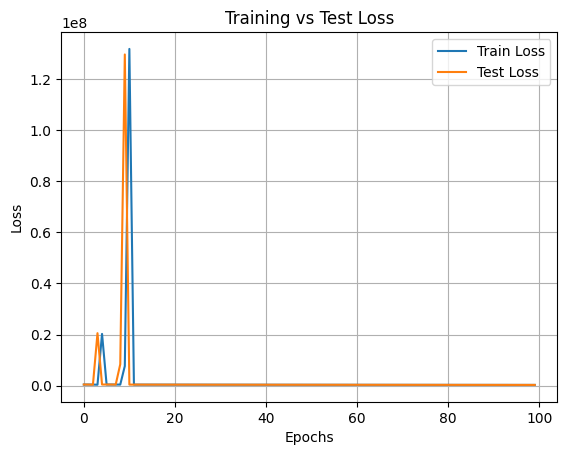

In [9]:
plot_loss(history_train_loss, history_test_loss)

### Evaluate regression model

In [10]:
def evaluate_regress_model(model, X_test, y_test):
    import torchmetrics

    mse_metric = torchmetrics.MeanSquaredError()
    mae_metric = torchmetrics.MeanAbsoluteError()
    r2_metric = torchmetrics.R2Score()

    with torch.inference_mode():
        test_preds = model(X_test)

    test_mse = mse_metric(test_preds, y_test)
    test_mae = mae_metric(test_preds, y_test)
    test_r2 = r2_metric(test_preds, y_test)
    test_rmse = torch.sqrt(test_mse)

    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test MAE: {test_mae:.4f}") 
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test R2: {test_r2:.4f}")

In [11]:
evaluate_regress_model(regress_model, test_features, test_credit_labels)

Test MSE: 291018.5625
Test MAE: 528.3415
Test RMSE: 539.4614
Test R2: -23.5093


### Logging the target variables
* Since our target variables are very comparing to train variables it is giving worst r2 score

In [12]:
train_credit_labels_log10 = torch.log10(train_credit_labels)
test_credit_labels_log10 = torch.log10(test_credit_labels)

In [13]:
train_credit_labels[:5]

tensor([[616.4602],
        [676.8171],
        [529.5679],
        [638.7054],
        [765.1794]])

In [14]:
regress_model_log10 = RegressionModel(in_features=train_features.shape[-1], h1=12, h2=6, out_features=1)
optimizer = optim.SGD(params=regress_model_log10.parameters(), lr = 0.01)
criterion = nn.MSELoss()

In [15]:
log_train_loss, log_test_loss = model_training(regress_model_log10, train_features, train_credit_labels_log10, test_features, test_credit_labels_log10, optimizer, criterion, n_epochs=100)

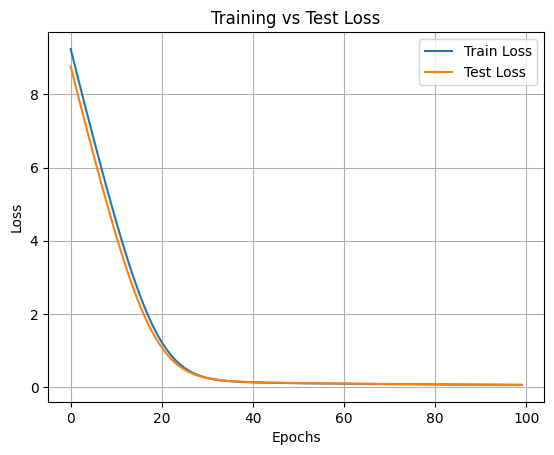

In [16]:
plot_loss(log_train_loss, log_test_loss)

In [17]:
evaluate_regress_model(regress_model_log10, test_features, test_credit_labels_log10)

Test MSE: 0.0627
Test MAE: 0.2015
Test RMSE: 0.2503
Test R2: -9.8570


### Standard scaling

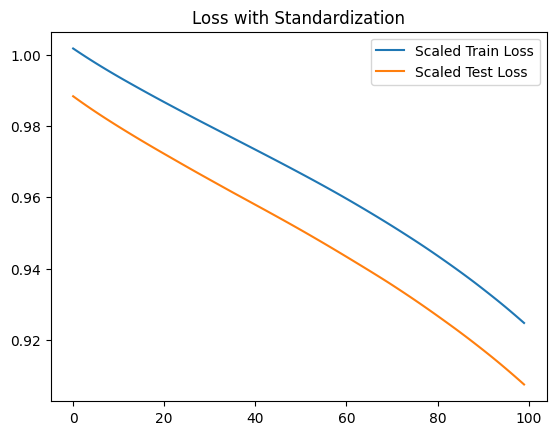

Test MSE: 0.9075
Test MAE: 0.7662
Test RMSE: 0.9526
Test R2: 0.0844


In [18]:
# 1. Calculate Mean and Std from TRAINING data only (to avoid data leakage)
mean_label = train_credit_labels.mean()
std_label = train_credit_labels.std()

# 2. Standardize Targets (make them roughly -1 to 1)
train_labels_scaled = (train_credit_labels - mean_label) / std_label
test_labels_scaled = (test_credit_labels - mean_label) / std_label

# 3. Re-Initialize Model
# We can use a slightly higher Learning Rate now because data is clean (~1.0)
regress_model_scaled = RegressionModel(in_features=train_features.shape[-1], h1=12, h2=6, out_features=1)
optimizer = optim.SGD(params=regress_model_scaled.parameters(), lr=0.01)
criterion = nn.MSELoss()

# 4. Train
scaled_train_loss, scaled_test_loss = model_training(
    regress_model_scaled, 
    train_features, 
    train_labels_scaled,    # Use SCALED targets
    test_features, 
    test_labels_scaled,     # Use SCALED targets
    optimizer, 
    criterion, 
    n_epochs=100
)

# 5. Plot Loss
import matplotlib.pyplot as plt
plt.plot(scaled_train_loss, label='Scaled Train Loss')
plt.plot(scaled_test_loss, label='Scaled Test Loss')
plt.legend()
plt.title("Loss with Standardization")
plt.show()

evaluate_regress_model(regress_model_scaled, test_features, test_labels_scaled)

## Regression Task with Smart weight initialization
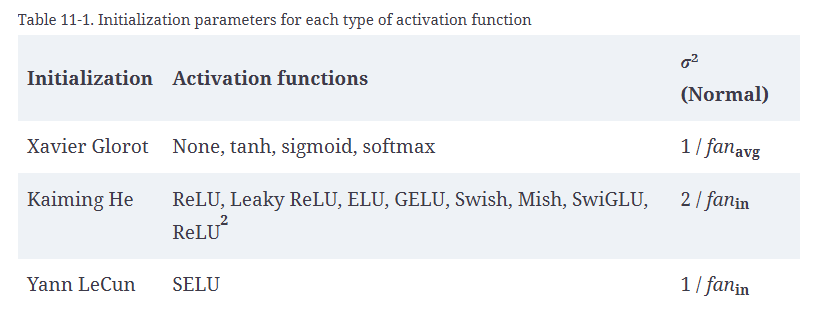

### Xavier Gloriot initialization

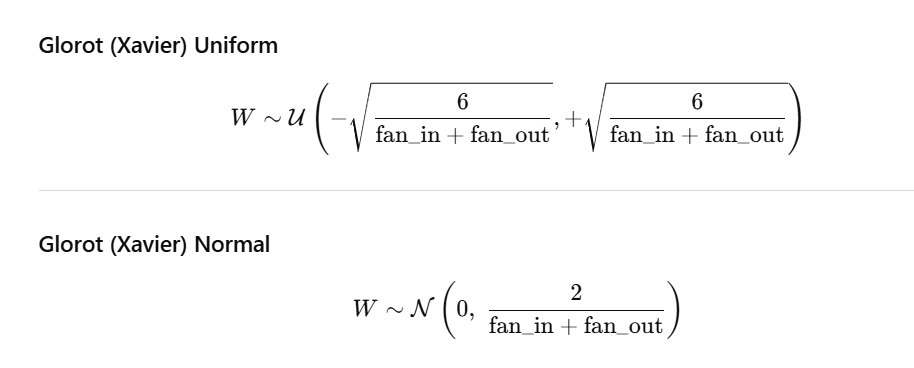

In [19]:
class RegressionModelGloriot(nn.Module):
    def __init__(self, in_features, h1, h2, out_features):
        super().__init__()
        self.input_layer = nn.Linear(in_features=in_features, out_features=h1)
        nn.init.xavier_uniform_(self.input_layer.weight)  # Glorot Initialization
        self.hidden_layer1 = nn.Linear(in_features=h1, out_features=h2)
        nn.init.xavier_uniform_(self.hidden_layer1.weight)  # Glorot Initialization
        self.output_layer = nn.Linear(in_features=h2, out_features=out_features)
        nn.init.xavier_uniform_(self.output_layer.weight)  # Glorot Initialization
    
    def forward(self, x):
        x = self.input_layer(x)
        x = torch.sigmoid(x)
        x = self.hidden_layer1(x)
        x = torch.sigmoid(x)
        x = self.output_layer(x)
        return x

In [20]:
gloriot_regress_model = RegressionModelGloriot(in_features=train_features.shape[-1], h1=12, h2=6, out_features=1)
optimizer = optim.Adam(params=gloriot_regress_model.parameters(), lr = 0.01)
criterion = nn.MSELoss()
gloriot_train_loss, gloriot_test_loss = model_training(gloriot_regress_model, train_features, train_credit_labels, test_features, test_credit_labels, optimizer, criterion, n_epochs=100)

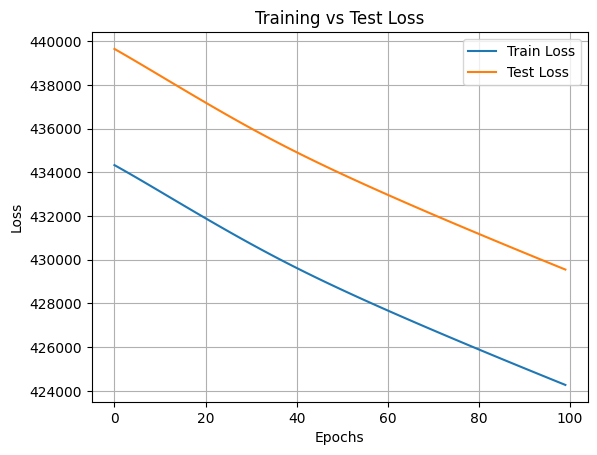

In [21]:
plot_loss(gloriot_train_loss, gloriot_test_loss)

In [22]:
evaluate_regress_model(gloriot_regress_model, test_features, test_credit_labels)

Test MSE: 429548.8125
Test MAE: 646.2789
Test RMSE: 655.3997
Test R2: -35.1762


#### scaling the labels

In [23]:
gloriot_regress_model_scaled = RegressionModelGloriot(in_features=train_features.shape[-1], h1=12, h2=6, out_features=1)
optimizer = optim.Adam(params=gloriot_regress_model_scaled.parameters(), lr=0.01)
criterion = nn.MSELoss()

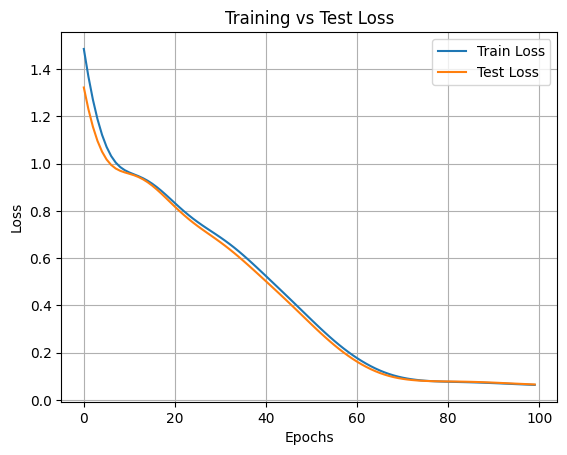

In [24]:

gloriot_train_loss, gloriot_test_loss = model_training(
    gloriot_regress_model_scaled, 
    train_features, 
    train_labels_scaled, 
    test_features, 
    test_labels_scaled,  
    optimizer, 
    criterion, 
    n_epochs=100
)
plot_loss(gloriot_train_loss, gloriot_test_loss)


In [25]:
evaluate_regress_model(gloriot_regress_model_scaled, test_features, test_labels_scaled)

Test MSE: 0.0661
Test MAE: 0.1707
Test RMSE: 0.2570
Test R2: 0.9333


## Batch Normalization
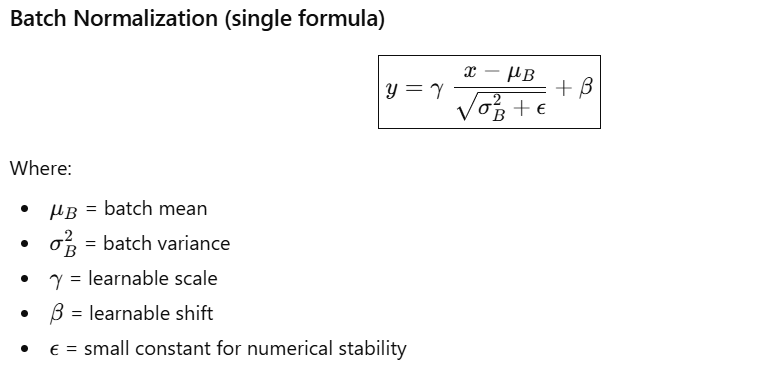

In [26]:
import torch
import torch.nn as nn
## Linear --> BatchNorm --> Sigmoid
class RegressionModelGlorotBN(nn.Module):
    def __init__(self, in_features, h1, h2, out_features):
        super().__init__()
        
        self.input_layer = nn.Linear(in_features=in_features, out_features=h1, bias=False)
        nn.init.xavier_uniform_(self.input_layer.weight)
        
        self.bn1 = nn.BatchNorm1d(num_features=h1) 
        
        self.hidden_layer1 = nn.Linear(in_features=h1, out_features=h2, bias=False)
        nn.init.xavier_uniform_(self.hidden_layer1.weight)
        
        self.bn2 = nn.BatchNorm1d(num_features=h2)
        
        self.output_layer = nn.Linear(in_features=h2, out_features=out_features)
        nn.init.xavier_uniform_(self.output_layer.weight)
    
    def forward(self, x):
        # Layer 1 Flow: Linear -> BN -> Activation
        x = self.input_layer(x)
        x = self.bn1(x)        # Normalize
        x = torch.sigmoid(x)   # Activation
        
        # Layer 2 Flow: Linear -> BN -> Activation
        x = self.hidden_layer1(x)
        x = self.bn2(x)        # Normalize
        x = torch.sigmoid(x)   # Activation
        
        # Output Flow
        x = self.output_layer(x)
        return x

In [27]:
gloriot_regress_modelBN_scaled = RegressionModelGlorotBN(in_features=train_features.shape[-1], h1=12, h2=6, out_features=1)
optimizer = optim.Adam(params=gloriot_regress_modelBN_scaled.parameters(), lr=0.01)
criterion = nn.MSELoss()

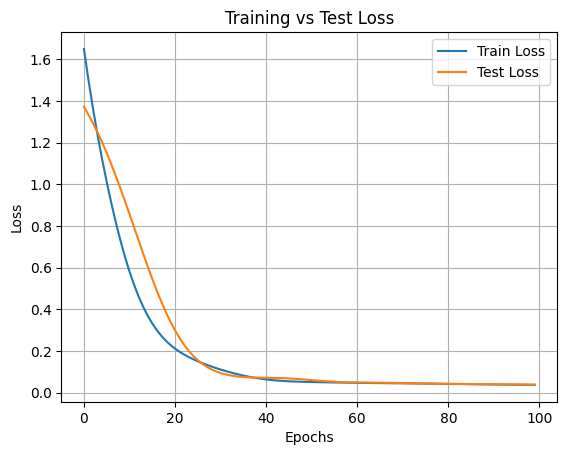

In [28]:

gloriot_train_loss, gloriot_test_loss = model_training(
    gloriot_regress_modelBN_scaled, 
    train_features, 
    train_labels_scaled, 
    test_features, 
    test_labels_scaled,  
    optimizer, 
    criterion, 
    n_epochs=100
)
plot_loss(gloriot_train_loss, gloriot_test_loss)


In [29]:
evaluate_regress_model(gloriot_regress_modelBN_scaled, test_features, test_labels_scaled)

Test MSE: 0.0393
Test MAE: 0.1117
Test RMSE: 0.1983
Test R2: 0.9603


## Transfer Learning

In [30]:
train_features.shape[-1]

20

In [31]:
list(gloriot_regress_modelBN_scaled.parameters())

[Parameter containing:
 tensor([[ 0.4434, -0.1919, -0.1908,  0.4552, -0.2718, -0.1900,  0.3692,  0.1486,
           0.1451, -0.2395, -0.1046, -0.0792,  0.3567, -0.3890,  0.4614,  0.1111,
           0.0509, -0.1415,  0.3688,  0.3120],
         [ 0.0443,  0.2662,  0.4926,  0.1764,  0.6674, -0.3874,  0.4267,  0.1219,
          -0.3425,  0.0993, -0.2470, -0.3542, -0.4920,  0.3921, -0.4399, -0.3116,
           0.0586,  0.0398,  0.0886, -0.0722],
         [-0.4964,  0.1228, -0.6302, -0.1472, -0.2116,  0.2551,  0.0705,  0.4392,
          -0.1528, -0.0763,  0.1033,  0.6215,  0.0877,  0.1159, -0.1267, -0.1237,
           0.0174, -0.2123, -0.3691,  0.2613],
         [-0.0401,  0.3525,  0.5098, -0.2299,  0.0372,  0.1292, -0.0387, -0.4090,
           0.0700, -0.0638,  0.5746, -0.0789,  0.1822,  0.1185,  0.0083, -0.1991,
          -0.5799, -0.2093,  0.1962, -0.2707],
         [-0.1213,  0.1434, -0.3442, -0.1903,  0.1705,  0.1546,  0.0847,  0.5132,
          -0.0797,  0.1562, -0.0964,  0.4655, -0.35

In [32]:
len(list(gloriot_regress_modelBN_scaled.parameters()))

8

In [33]:
h1_plus_bias = list(gloriot_regress_modelBN_scaled.parameters())[1]

In [34]:
class NewTransferModel(nn.Module):
    def __init__(self, in_features, h1, new_h2, out_features):
        super().__init__()
        
        # 1. REUSE: We will overwrite these later, but we define the shape to match
        self.transferred_layer = nn.Linear(in_features, h1, bias=False)
        self.transferred_bn = nn.BatchNorm1d(h1)
        
        # 2. NEW: This is the fresh part we want to train
        self.new_hidden = nn.Linear(h1, new_h2)
        self.new_output = nn.Linear(new_h2, out_features)
        
    def forward(self, x):
        # Old Learned Features
        x = self.transferred_layer(x)
        x = self.transferred_bn(x)
        x = torch.sigmoid(x)
        
        # New Learning
        x = self.new_hidden(x)
        x = torch.relu(x)
        x = self.new_output(x)
        return x

In [35]:
# 1. Instantiate the New Model
# Note: h1 must match the old model (12)
transfer_model = NewTransferModel(in_features=20, h1=12, new_h2=32, out_features=1)

# 2. COPY the Trained Layers (The "Transfer" Step)
# This copies Weights, Biases, AND Batch Norm statistics (running_mean/var)
transfer_model.transferred_layer = gloriot_regress_modelBN_scaled.input_layer
transfer_model.transferred_bn = gloriot_regress_modelBN_scaled.bn1

print("Transfer Complete: Old layers injected into New Model.")

Transfer Complete: Old layers injected into New Model.


In [36]:
# Freeze Linear Layer
for param in transfer_model.transferred_layer.parameters():
    param.requires_grad = False

# Freeze Batch Norm Layer
for param in transfer_model.transferred_bn.parameters():
    param.requires_grad = False
    
print("Layers Frozen. Backprop will only update the NEW layers.")

Layers Frozen. Backprop will only update the NEW layers.


## Classification Task

### Model building

In [37]:
class ClassificationModel(nn.Module):
    def __init__(self, in_features, h1, h2, out_features):
        super().__init__()
        self.input_layer = nn.Linear(in_features=in_features, out_features=h1)
        self.hidden_layer1 = nn.Linear(in_features=h1, out_features=h2)
        self.output_layer = nn.Linear(in_features=h2, out_features=out_features)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = torch.relu(x)
        x = self.hidden_layer1(x)
        x = torch.relu(x)
        x = self.output_layer(x)
        return x

In [38]:
classify_model = ClassificationModel(in_features=train_features.shape[-1], h1=12, h2=6, out_features=1)
optimizer = optim.Adam(params=classify_model.parameters(), lr = 0.001)
criterion = nn.BCEWithLogitsLoss()

In [39]:
classify_train_loss, classify_test_loss = model_training(
    classify_model,
    train_features,
    train_churn_labels,
    test_features,
    test_churn_labels,
    optimizer,
    criterion,
    n_epochs=100
)

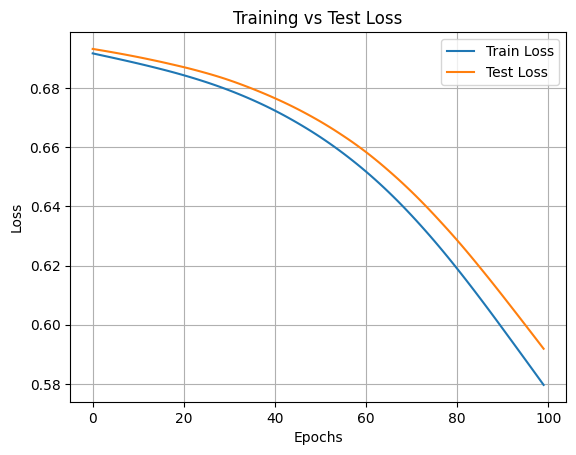

In [40]:
plot_loss(classify_train_loss, classify_test_loss)

In [41]:
def evaluate_classification_model(model, X_test, y_test):
    from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
    accuracy_metric = Accuracy(task="binary")
    precision_metric = Precision(task="binary")
    recall_metric = Recall(task="binary")
    f1_metric = F1Score(task="binary")
    confusion_matrix_metric = ConfusionMatrix(task="binary",num_classes=2)

    with torch.inference_mode():
        test_logits = model(X_test)
        test_preds = torch.sigmoid(test_logits)
        test_preds_labels = (test_preds >= 0.5).float()

    test_accuracy = accuracy_metric(test_preds_labels, y_test)
    test_precision = precision_metric(test_preds_labels, y_test)
    test_recall = recall_metric(test_preds_labels, y_test)
    test_f1 = f1_metric(test_preds_labels, y_test)
    test_confusion_matrix = confusion_matrix_metric(test_preds_labels, y_test)

    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Confusion Matrix:\n{test_confusion_matrix}")


In [42]:
evaluate_classification_model(classify_model, test_features, test_churn_labels)

Test Accuracy: 0.7350
Test Precision: 0.6891
Test Recall: 0.8367
Test F1 Score: 0.7558
Confusion Matrix:
tensor([[130,  74],
        [ 32, 164]])
